# About this NB:
- using the pixel size changed dataset [https://www.kaggle.com/code/gunesevitan/pixel-size-and-tissue-thickness-domain-adaptation]

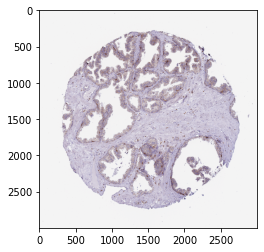

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 
import matplotlib.pyplot as plt
from tqdm import tqdm
IMG = cv2.cvtColor(cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10044.tiff"), cv2.COLOR_BGR2RGB)
plt.imshow(IMG)

In [2]:
!mkdir -p fixed_blur_image

In [7]:
blur_ids = [435, 737, 928, 1184, 1229, 1500, 1690, 1955,2174,3409, 4639, 4658, 4802,4944,5287,5317, 
             5785, 5932, 5995, 6120, 6390, 6730, 6794, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 
             9358, 10044,10274, 10666, 10912, 10971, 12233, 12244, 13483, 13942, 14396, 14407, 15706, 
             15732, 16149, 16609, 16659, 17143, 17187, 17455, 17828,18422, 19084, 19569, 20247, 20428, 
             20955, 21086, 21155, 22016, 22059, 22995, 23009, 23640, 23828, 23959, 23961, 24194, 24269, 
             24961, 25430, 28622, 29213, 29223, 29296, 29307, 29809, 30080, 30294, 30355, 30414, 30424, 
             30765, 31898, 31958, 32009, 32126, 32412, 32741]

DEST_DIR = "/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size"

# read these images and save them on a seperate folder, if they come correct then paste them
for img_id in tqdm(blur_ids):
    try:
        IMG = cv2.cvtColor(cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/" + str(img_id) + ".tiff"), cv2.COLOR_BGR2RGB)
        fname = DEST_DIR + "/" + str(img_id) + ".png"
        cv2.imwrite(fname, IMG)
    except:
        print(img_id)

100%|██████████| 90/90 [00:42<00:00,  2.11it/s]


In [1]:
import staintools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import tifffile
import sys
import os
import numpy as np
from scipy import interpolate
from scipy.ndimage import morphology
from scipy.stats import multivariate_normal
from PIL import Image, ImageDraw
from cv2 import GaussianBlur, blur, getPerspectiveTransform, warpPerspective

from hashlib import blake2s

from deconvolution import Deconvolution
import deconvolution.pixeloperations as po


sys.path.append("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/histopath_failure_modes")
from image_manipulation import img_manip

In [2]:
TRAIN_CSV = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv"
df = pd.read_csv(TRAIN_CSV)
# df.head()
df_lung = df[df['organ'] == 'lung']
df_lung.__len__(), df['organ'].value_counts()

(48,
 kidney            99
 prostate          93
 largeintestine    58
 spleen            53
 lung              48
 Name: organ, dtype: int64)

In [ ]:
DIR = "/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size"

img_path = DIR + "/" +str(df_lung['id'].iloc[10]) + ".png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)

img_with_bubbles = img_manip.add_bubbles(im_pil, alpha=0.55, maxWidth = 120, nBubbles = 150)

plt.imshow(img_with_bubbles)

In [2]:
def plot_tissue_with_generated_artifact(img, mask, augmented_img, augmentation):
    img = np.array(img)
    mask = np.array(mask)
    augmented_img = np.array(augmented_img)
    fig, axs = plt.subplots(1, 2, figsize = (16, 8), sharex = True, sharey = True)

    axs[0].imshow(color.label2rgb(mask, img, bg_label = 0, bg_color = (1.,1.,1.), alpha = 0.25))
    axs[0].set_title("Original image", fontsize = 14)
    axs[0].axis('off')

    axs[1].imshow(color.label2rgb(mask, augmented_img, bg_label = 0, bg_color = (1.,1.,1.), alpha = 0.25))
    axs[1].set_title(f"{augmentation}", fontsize = 14)
    axs[1].axis('off')
    plt.show();

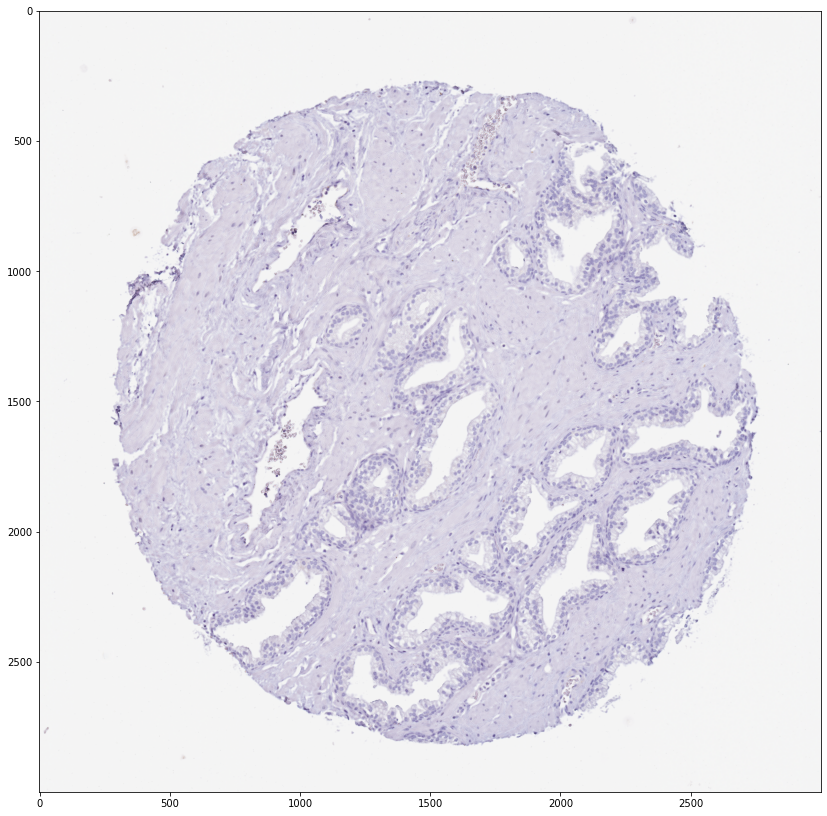

In [3]:
plt.figure(figsize=(14,18))
plt.imshow(plt.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/1184.tiff"))

In [4]:
import tifffile as tiff

# temp images =----------------
img_ = cv2.cvtColor(tiff.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10044.tiff"), cv2.COLOR_BGR2RGB)
mask_ = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/10044.png",0).astype(np.float32)

# mask_.shape, img_.shape
np.size(img_)

27000000

In [5]:
def rand_gauss(dim, nNorms = 25, maxCov = 50,  random_seed = None,centXY = None, zeroToOne = False,
               minMaxX = None, minMaxY = None, minCovScale = .1,minDiagCovScale = .25, maxCrCovScale = .7):
    
    np.random.seed(seed=random_seed)
    invDim = (dim[1],dim[0])
     
    if zeroToOne == True:
        xV = np.linspace(0,1,num= dim[0])
        yV = np.linspace(0,1,num= dim[1])
        if minMaxX is None:
            minMaxX = [0,1]
        if minMaxY is None:
            minMaxY = [0,1]
    else:
        xV = np.arange(dim[0])
        yV = np.arange(dim[1])
        
        if minMaxX is None:
            minMaxX = [0,dim[0]]
        if minMaxY is None:
            minMaxY = [0,dim[1]]

    xM, yM = np.meshgrid(xV,yV)
    pos = np.dstack((xM, yM))
    
    if centXY is None:
        centXY = np.concatenate((np.random.uniform(minMaxX[0],minMaxX[1],size=(nNorms,1)),
                        np.random.uniform(minMaxY[0],minMaxY[1],size=(nNorms,1))), axis=1)
    else:
        nNorms = centXY.shape[0]
    
    sumMap = np.zeros(invDim)
    for i in range(nNorms):
        cent = centXY[i,:]
        cov = np.zeros((2,2))
        # need to make a symmetric positive semidefinite covariance matrix
        cMaxCov = np.random.uniform(maxCov* minCovScale,maxCov,size=(1,1))
        cov = np.diag(np.random.uniform(cMaxCov * minDiagCovScale,cMaxCov,size=(1,2)).flatten())
        maxCrCov = np.sqrt(np.product(np.diag(cov)))
        cov[[0,1],[1,0]] = np.random.uniform(-maxCrCov* maxCrCovScale,maxCrCov*maxCrCovScale) 
        rv = multivariate_normal(cent.flatten(), cov)
        
        sumMap += (rv.pdf(pos) * (cMaxCov * 2 * np.pi))

    sumMap = sumMap * maxCov
    return sumMap

def add_bubbles(inputIm,random_seed = None,nBubbles = 25, maxWidth = 50,alpha = .75, edgeWidth = 2,
                edgeColorMult = (.75,.75,.75), rgbVal = (225,225,225)):
    np.random.seed(seed=random_seed)
    print(inputIm.shape)
    dim = inputIm.shape[:2] # width by height
    print(dim)
    invDim = (dim[1],dim[0]) # have to invert the size dim because rows cols is yx vs xy
    
    # use the randomized gaussian function
    sumMap = rand_gauss(dim,random_seed = random_seed, nNorms=nBubbles, maxCov = maxWidth, zeroToOne = False,
                       minCovScale = .1,minDiagCovScale = .25, maxCrCovScale = .7)
    
    bwReg = sumMap >= 1
    bwDist = morphology.distance_transform_edt(bwReg)
    edgeArea = np.logical_and(bwDist <= edgeWidth,bwReg)
    # print(bwReg.shape)
    alphaMask = np.array((bwReg*alpha*255).astype(np.uint8))
    colorArr = np.zeros((invDim[0],invDim[1],3),dtype=np.uint8)
    # return alphaMask

    # set the colors for the bubbles & edges
    meanColor = np.mean(np.array(inputIm),axis=(0,1))
    for i in range(len(rgbVal)):
        colorArr[:,:,i] = rgbVal[i]
        colorArr[edgeArea,i] = np.uint8(meanColor[i] * edgeColorMult[i])

    # print(colorArr.shape)
    # color_layer = cv2.cvtColor(colorArr,cv2.COLOR_GRAY2RGB)#cv2.cvtColor#Image.fromarray(colorArr,'RGB')
    # print(type(color_layer))
    dest = cv2.addWeighted(colorArr, 0.5, inputIm, 0.5, 0.0)
    # comp_im = Image.composite(color_layer, inputIm, alphaMask)
    return dest

In [6]:
img_ = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/32126_00.png", cv2.IMREAD_COLOR)
img_with_bubbles = add_bubbles(img_)

(1024, 1024, 3)
(1024, 1024)


In [7]:
# plt.figure(figsize=(14,18))
# plt.imshow(img_with_bubbles)
# plt.title("cv2 image read");

In [8]:
# img = Image.open("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/32126_00.png")  
# img_with_bubbles = img_manip.add_bubbles(img)
# plt.figure(figsize=(14,18))
# plt.imshow(img_with_bubbles)
# plt.title("pil/plt.imread() image read example");

In [9]:
# np.array(img)

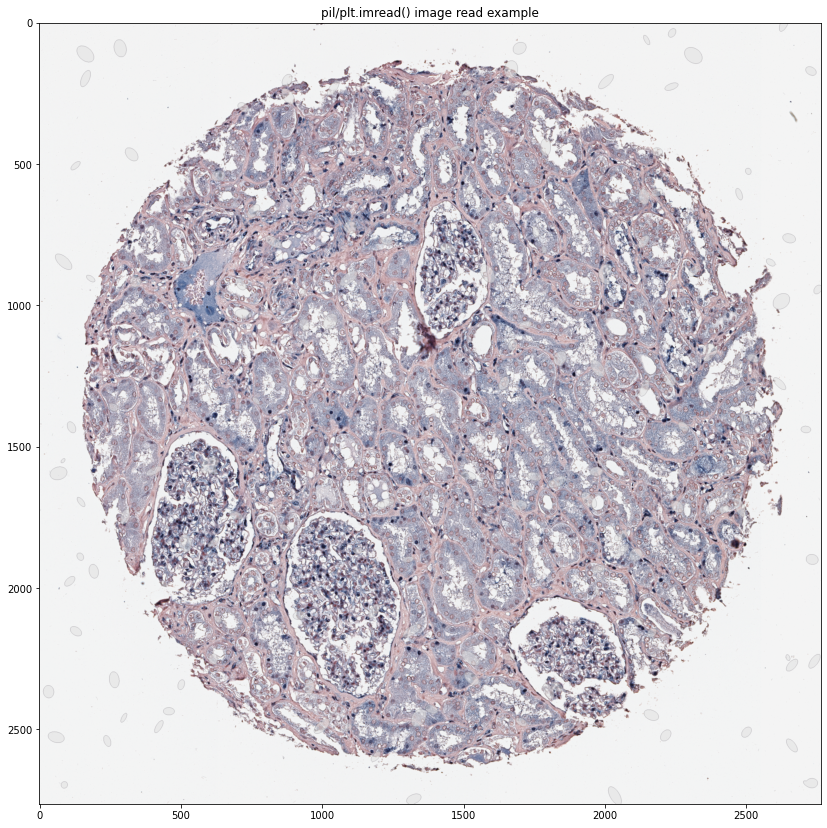

In [18]:
"""
params for 3000 img size: alpha=0.55, maxWidth = 120, nBubbles = 150
"""

img = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-22-aug-pixel-size/2344.png")  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)

img_with_bubbles = img_manip.add_bubbles(im_pil, alpha=0.55, maxWidth = 120, nBubbles = 150)

plt.figure(figsize=(14,18))
plt.imshow(img_with_bubbles)
plt.title("pil/plt.imread() image read example");

In [19]:
img

array([[[243, 242, 243],
        [242, 243, 242],
        [242, 244, 243],
        ...,
        [244, 244, 245],
        [245, 244, 244],
        [244, 245, 243]],

       [[244, 244, 244],
        [242, 243, 243],
        [242, 243, 243],
        ...,
        [243, 245, 244],
        [244, 245, 245],
        [242, 244, 244]],

       [[244, 246, 244],
        [243, 243, 243],
        [243, 242, 244],
        ...,
        [244, 245, 245],
        [245, 244, 245],
        [243, 243, 245]],

       ...,

       [[243, 245, 245],
        [244, 245, 245],
        [245, 245, 245],
        ...,
        [245, 245, 244],
        [243, 245, 245],
        [243, 243, 244]],

       [[244, 245, 245],
        [244, 245, 244],
        [243, 245, 244],
        ...,
        [244, 245, 244],
        [243, 245, 245],
        [243, 243, 244]],

       [[244, 245, 245],
        [243, 244, 243],
        [243, 244, 243],
        ...,
        [243, 244, 244],
        [243, 245, 244],
        [244, 244, 245]]

# List of augmentations to try:
- Sectioning
- bubble
- Stain alteration
- Tissue tears

In [15]:
# img = Image.open(tiles_img[8])
# mask = Image.open(tiles_seg[8])
# Optional parameters for add_bubbles() method includes:
    #     random_seed: int          The random seed for numpy for consistent generation
    #     nBubbles: int (+)         The number of bubbles to generate in the image
    #     maxWidth: float (+)       The maximum width of the randomized bubbles (roughly), in pixels
    #     alpha: float (0-1)        The alpha transparency of the bubble layer (1 = opaque, 0 = transparent)
    #     edgeWidth: float (+)      The width of the darker edge of the bubble, in pixels
    #     edgeColorMult:            The RGB multiplier of the edge of the bubble 
    #        3 float vector         -Relative to the mean RGB color of the image
    #     rgbVal: 3 float vector    The RGB color of the bubbles

# Here the default value fol nBubbles is 25
img_with_bubbles = img_manip.add_bubbles(img_)

plot_tissue_with_generated_artifact(img_, mask_, img_with_bubbles, "Image with Bubbles")

TypeError: 'int' object is not subscriptable

In [ ]:
/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv

In [3]:
normed_path = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-aug-pixel-size-stain-norm/"
# img_norm = cv2.cvtColor(tifffile.imread(normed_path+"10044.png"), cv2.COLOR_BGR2RGB)
image = cv2.imread(normed_path+"10044.png", cv2.IMREAD_COLOR)
image.shape[:2]
# plt.imshow(image)

(3000, 3000)

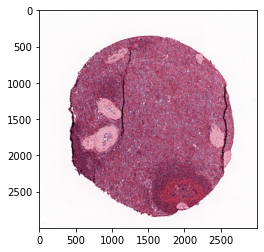

In [6]:



DIR = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-22-aug-pixel-size"
target = staintools.read_image("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/test_images/10078.tiff")
to_transform = staintools.read_image("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-22-aug-pixel-size/10392.png")

# Standardize brightness (optional, can improve the tissue mask calculation)
target = staintools.LuminosityStandardizer.standardize(target)
to_transform = staintools.LuminosityStandardizer.standardize(to_transform)

# Stain normalize
normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(target)
transformed1 = normalizer.transform(to_transform)
plt.imshow(transformed1)

In [5]:
cv2.imwrite("demo.png", transformed1)

True

In [22]:
!mkdir -p /home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-aug-pixel-size-stain-norm

dest_dir = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-aug-pixel-size-stain-norm"
target = staintools.read_image("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/test_images/10078.tiff")
for i in tqdm(range(len(os.listdir(DIR)))):
    file_list = os.listdir(DIR)
    img_path = os.path.join(DIR, file_list[i])
    to_transform = staintools.read_image(img_path)

    # Standardize brightness (optional, can improve the tissue mask calculation)
    target = staintools.LuminosityStandardizer.standardize(target)
    to_transform = staintools.LuminosityStandardizer.standardize(to_transform)

    # Stain normalize
    normalizer = staintools.StainNormalizer(method='vahadane')
    normalizer.fit(target)
    transformed1 = normalizer.transform(to_transform)

    norm_fname = os.path.join(dest_dir, file_list[i]) 
    cv2.imwrite(norm_fname, transformed1)

100%|██████████| 351/351 [35:23<00:00,  6.05s/it]


In [12]:

import torch
import numpy as np
import tifffile
import staintools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def rand_bbox(size, lam):
    """
    Retuns the coordinate of a random rectangle in the image for cutmix.

    Args:
        size (torch tensor [batch_size x c x W x H): Input size.
        lam (int): Lambda sampled by the beta distribution. Controls the size of the squares.

    Returns:
        int: 4 coordinates of the rectangle.
        int: Proportion of the unmasked image.
    """
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    return bbx1, bby1, bbx2, bby2, lam


def cutmix_data(x, y, alpha=1.0, device="cuda"):
    """
    Applies cutmix to a sample

    Args:
        x (torch tensor [batch_size x input_size]): Input batch.
        y (torch tensor [batch_size x num_classes]): Labels.
        alpha (float, optional): Parameter of the beta distribution. Defaults to 1..
        device (str, optional): Device for torch. Defaults to "cuda".

    Returns:
        torch tensor [batch_size x input_size]: Mixed input.
        torch tensor [batch_size x num_classes]: Mixed labels.
        float: Probability sampled by the beta distribution.
    """
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1

    index = torch.randperm(x.size()[0]).to(device)

    bbx1, bby1, bbx2, bby2, lam = rand_bbox(x.size(), lam)

    mixed_x = x.clone()
    mixed_y = y.clone()

    mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    mixed_y[:, bbx1:bbx2, bby1:bby2] = y[index, bbx1:bbx2, bby1:bby2]

    return mixed_x, mixed_y


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_img(id_):
    image = cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/"+ str(id_) +".tiff"), cv2.COLOR_BGR2RGB)
    image = torch.from_numpy(image).permute(2,1,0)
    return image

def get_mask(id_):
    mask = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/"+str(id_)+".png", 0)
    mask = torch.from_numpy(mask).unsqueeze(0)
    return mask

image1, image2 = get_img(127), get_img(351)
mask1, mask2 = get_mask(127), get_mask(351)
mask = torch.as_tensor([mask1.numpy(), mask2.numpy()])
# image = torch.as_tensor([image1.numpy(), image2.numpy()])
image = torch.as_tensor([image1.numpy()])

# image.shape
# mix_data = cutmix_data(image, mask, alpha=1.0, device=device)
# x,y = image, mask

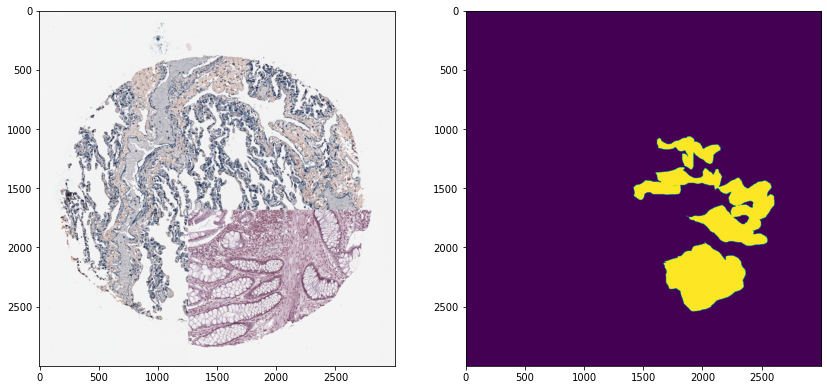

In [188]:
mix_data[0].shape #2, 3, 3000, 3000
plt.figure(figsize=(14,16))
plt.subplot(1,2,1)
plt.imshow(mix_data[0][0,:,:,:].permute(1,2,0).detach().numpy())
plt.subplot(1,2,2)
plt.imshow(mix_data[1][0,:,:,:].detach().numpy().reshape(3000,3000))


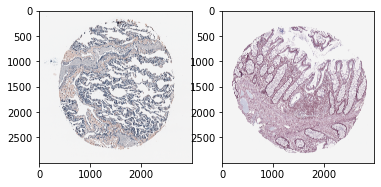

In [185]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff"), cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/351.tiff"), cv2.COLOR_BGR2RGB))


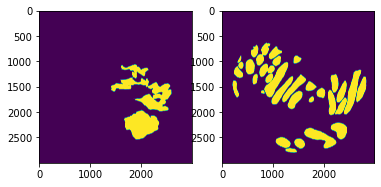

In [186]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0))

plt.subplot(1,2,2)
plt.imshow(cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/351.png", 0))

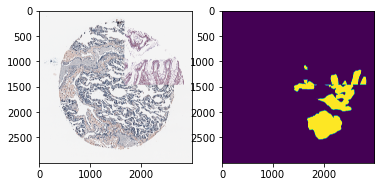

In [11]:
image1 = cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/351.tiff"), 
                        cv2.COLOR_BGR2RGB)
mask1 = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/351.png", 0)

image2 = cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff"), 
                        cv2.COLOR_BGR2RGB)
mask2 = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0)

alpha = 0.7
lam = np.random.beta(alpha, alpha) if alpha > 0 else 1

W,H,_ = image1.shape

cx = np.random.randint(W)
cy = np.random.randint(H)

cut_rat = np.sqrt(1.0 - lam)
cut_w = np.int(W * cut_rat)
cut_h = np.int(H * cut_rat)
bbx1 = np.clip(cx - cut_w // 2, 0, W)

bbx1 = np.clip(cx - cut_w // 2, 0, W)
bby1 = np.clip(cy - cut_h // 2, 0, H)
bbx2 = np.clip(cx + cut_w // 2, 0, W)
bby2 = np.clip(cy + cut_h // 2, 0, H)

img = np.copy(image1)

image2[bbx1:bbx2, bby1:bby2, :] = image1[bbx1:bbx2, bby1:bby2, :]
mask2[bbx1:bbx2, bby1:bby2] = mask1[bbx1:bbx2, bby1:bby2]

plt.subplot(1,2,1)
plt.imshow(image2)

plt.subplot(1,2,2)
plt.imshow(mask2)

In [169]:
# mask1.shape

(3000, 3000)

In [14]:
image.shape[:2]

torch.Size([1, 3])

In [3]:
def cutout_custom(tensor,alpha=0.5):
    x=int(alpha*tensor.shape[2])
    y=int(alpha*tensor.shape[3])
    center=np.random.randint(0,tensor.shape[2],size=(2))
    #perm = torch.randperm(img.shape[0])
    cut_tensor=tensor.clone()
    cut_tensor[:,:,center[0]-x//2:center[0]+x//2,center[1]-y//2:center[1]+y//2]=0
    return cut_tensor

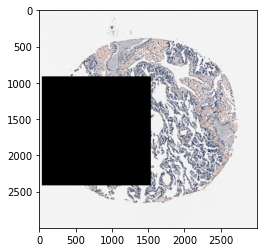

In [7]:
plt.imshow(cutout_custom(image)[0,:,:,:].permute(1,2,0).detach().numpy())

In [130]:
lam = np.random.beta(1.0, 1.0) if 1.0 > 0 else 1

index = torch.randperm(x.size()[0]).to(device)

bbx1, bby1, bbx2, bby2, lam = rand_bbox(x.size(), lam)

mixed_x = x.clone()
mixed_y = y.clone()

print(x[index, :, bbx1:bbx2, bby1:bby2].shape, y[index, bbx1:bbx2, bby1:bby2].shape)
mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
mixed_y[:, bbx1:bbx2, bby1:bby2] = y[index, bbx1:bbx2, bby1:bby2]


torch.Size([2, 3, 732, 732]) torch.Size([2, 0, 732, 3000])


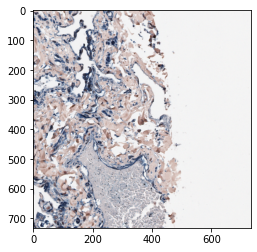

In [131]:
plt.imshow(x[index, :, bbx1:bbx2, bby1:bby2][1,:,:,:].permute(1,2,0).detach().numpy())

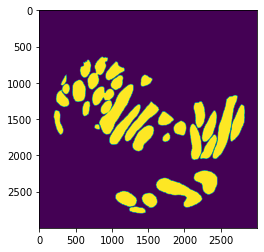

In [132]:
plt.imshow(mixed_y[1,:,:,:].detach().numpy().reshape(3000,3000))

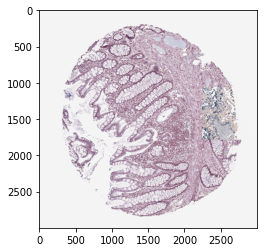

In [133]:
plt.imshow(mixed_x[1,:,:,:].permute(1,2,0).detach().numpy())

In [95]:
mixed_x[1,:,:,:].permute(1,2,0).detach().numpy().T.shape

(3, 3000, 3000)

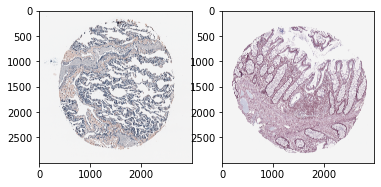

In [122]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff"), cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/351.tiff"), cv2.COLOR_BGR2RGB))


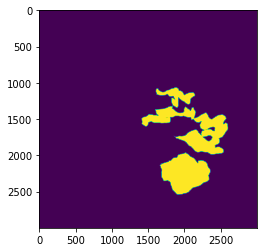

In [51]:
plt.imshow(mix_data[1][1,:,:,:].detach().numpy().reshape(3000,3000))

In [53]:
mix_data[0].shape

torch.Size([2, 3, 3000, 3000])

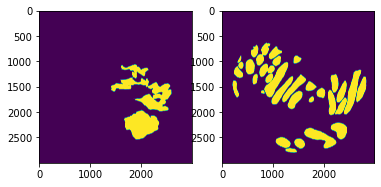

In [123]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0))

plt.subplot(1,2,2)
plt.imshow(cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/351.png", 0))

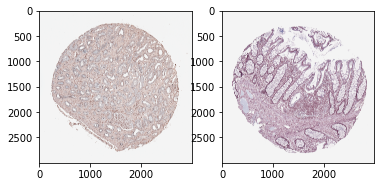

In [113]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/62.tiff"), cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/351.tiff"), cv2.COLOR_BGR2RGB))


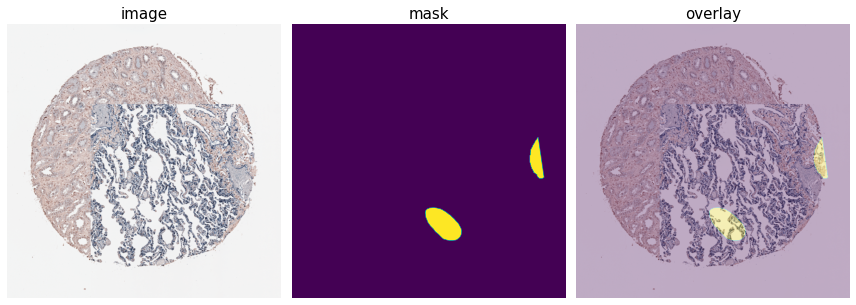

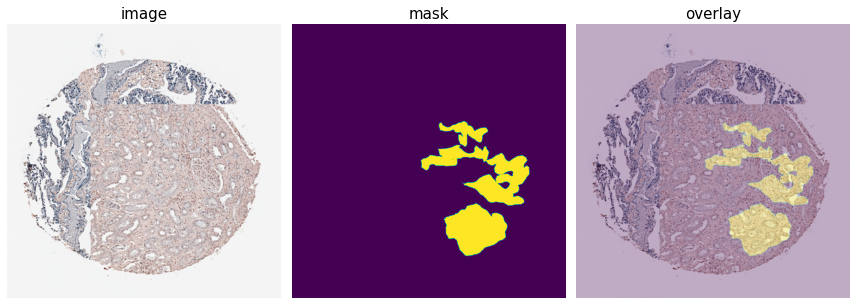

In [59]:
# items = next(iter(train_loader))
imgs = mix_data[0].permute((0, 2, 3, 1))
msks = mix_data[1].permute((0, 2, 3, 1))
imgs.size(), msks.size()

import matplotlib.pyplot as plt
def plot_batch(imgs, msks, size=2):
    for idx in range(size):
        plt.figure(figsize=(4*3, 5))

        plt.subplot(1, 3, 1); plt.imshow(imgs[idx])
        plt.title('image', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 2); plt.imshow(msks[idx])
        plt.title('mask', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 3); plt.imshow(imgs[idx]); plt.imshow(msks[idx], alpha=0.3)
        plt.title('overlay', fontsize=15)
        plt.axis('OFF')
        
        plt.tight_layout()
        plt.show()

plot_batch(imgs, msks, size=2)